In [56]:
import pandas as pd 
import numpy as np 
import os, pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

In [57]:
# creating customise transformer for the data preprocessing 

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        print("Init is called!")
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X["rooms_per_household"] = X["total_rooms"] / X["households"]
        X["bedrooms_per_room"] = X["total_bedrooms"] / X["total_rooms"]
        X["population_per_household"] = X["population"] / X["households"]

        return X 
    
    


In [58]:
# def data_preprocessing_2(housing, processed_datapath=None):
    
#     train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
    
#     housing["income_cat"] = pd.cut(
#             housing["median_income"],
#             bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
#             labels=[1, 2, 3, 4, 5],
#         )
    
#     split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#     for train_index, test_index in split.split(housing, housing["income_cat"]):
#         strat_train_set = housing.loc[train_index]
#         strat_test_set = housing.loc[test_index]
    
#     for set_ in (strat_train_set, strat_test_set):
#         set_.drop("income_cat", axis=1, inplace=True)
    
#     housing = strat_train_set.drop("median_house_value",axis=1)
#     housing_labels = strat_train_set["median_house_value"].copy()
    
#     return housing.shape

In [59]:
def income_cat_proportions(data):
    
    return data["income_cat"].value_counts() / len(data)

In [60]:
def data_preprocessing(housing, processed_datapath="./"):
    
    train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

    housing["income_cat"] = pd.cut(
        housing["median_income"],
        bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
        labels=[1, 2, 3, 4, 5],
    )

    
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]
    #logger.info("Stratified Shuffle split completed")
    train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

    #logger.info("Creating DataFrame for data preprocessing with income_cat_proportions")
    compare_props = pd.DataFrame(
        {
            "Overall": income_cat_proportions(housing),
            "Stratified": income_cat_proportions(strat_test_set),
            "Random": income_cat_proportions(test_set),
        }
    ).sort_index()
    #logger.info("Rand>%error column creating in compare_props variable")
    compare_props["Rand. %error"] = (
        100 * compare_props["Random"] / compare_props["Overall"] - 100
    )
    compare_props["Strat. %error"] = (
        100 * compare_props["Stratified"] / compare_props["Overall"] - 100
    )

    for set_ in (strat_train_set, strat_test_set):
        set_.drop("income_cat", axis=1, inplace=True)

    housing = strat_train_set.copy()
    housing.plot(kind="scatter", x="longitude", y="latitude")
    housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

    corr_matrix = housing.corr()
    corr_matrix["median_house_value"].sort_values(ascending=False)
    housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
    housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
    housing["population_per_household"] = housing["population"] / housing["households"]

    housing = strat_train_set.drop(
        "median_house_value", axis=1
    )  # drop labels for training set
    housing_labels = strat_train_set["median_house_value"].copy()
    #logger.info("Creating an instance of SimpleImputer")
    imputer = SimpleImputer(strategy="median")

    housing_num = housing.drop("ocean_proximity", axis=1)
    #logger.info("Dropping ocean_proximity Column")
    imputer.fit(housing_num)
    #logger.info("imputer fitted on housing_num")
    X = imputer.transform(housing_num)

    housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
    coltrans = CombinedAttributesAdder()
    housing_tr = coltrans.transform(housing_tr)

    housing_cat = housing[["ocean_proximity"]]
    housing_prepared = housing_tr.join(pd.get_dummies(housing_cat, drop_first=True))

    #logger.info(f"Storing the processed data at {processed_datapath}")
    housing_prepared.to_csv(
        os.path.join(processed_datapath, "housing_prepared.csv"), index=False
    )
    housing_labels.to_csv(
        os.path.join(processed_datapath, "housing_labels.csv"), index=False
    )
    strat_test_set.to_csv(
        os.path.join(processed_datapath, "strat_test_set.csv"), index=False
    )
    #logger.info(f"Dumping Imputer for testing use @ {processed_datapath}")
    pickle.dump(
        imputer,
        open(processed_datapath + "/imputer.pkl", "wb"),
    )
    return True

In [61]:
df = pd.read_csv(r'../data/raw/housing/housing/housing.csv')
df.shape

(20640, 10)

Init is called!


True

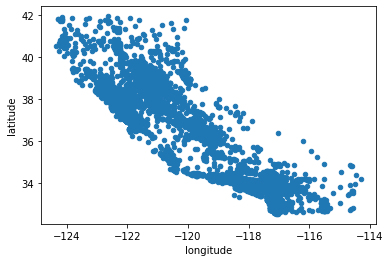

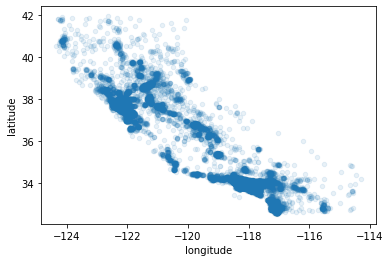

In [62]:
data_preprocessing(df,"./")